In [1]:
!pip install diffusers==0.16.1

In [2]:
!pip install traker==0.1.3

In [3]:
!pip install fast-jl==0.1.3

In [4]:
# !pip list

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
####
import torch
import random
import numpy as np
from accelerate.utils import ProjectConfiguration, set_seed

def set_seeds(seed):
    set_seed(seed)
    
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)
####

In [3]:
torch.__version__

'2.0.1+cu117'

In [4]:
from datasets import load_dataset


In [6]:
from diffusers import DDPMPipeline, DDIMPipeline, DDPMScheduler
from torchvision import transforms

In [7]:
pipe = DDIMPipeline.from_pretrained("anton-l/ddpm-ema-flowers-64").to('cuda')

unet/diffusion_pytorch_model.safetensors not found


In [9]:
generator = [torch.Generator('cpu').manual_seed(i) for i in range(64)]
        
images = pipe(
            generator=generator,
            batch_size=64,
            num_inference_steps=50,
            output_type="numpy",
            eta=0.0,
).images

len(images)

  0%|          | 0/50 [00:00<?, ?it/s]

64

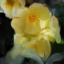

In [10]:
images = pipe.numpy_to_pil(images)
images[0]

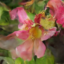

In [11]:
images[1]

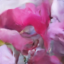

In [12]:
images[2]

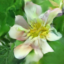

In [13]:
images[3]

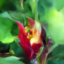

In [14]:
images[4]

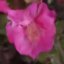

In [15]:
images[5]

In [1]:
# train_dataset = load_dataset("huggan/flowers-102-categories", split="train").select(range(0, 256))
train_dataset = load_dataset("huggan/flowers-102-categories", split="train")
train_dataset[0]['image']

In [17]:
train_dataset

Dataset({
    features: ['image'],
    num_rows: 8189
})

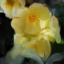

In [18]:
from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "image": images,
})
})
gen_dataset = dataset["train"]
gen_dataset[0]['image']

In [19]:
class Args():
    train_batch_size=16
    dataloader_num_workers=8
    
    resolution=64
    center_crop=True
    random_flip=False
    
    ddpm_num_steps=1000
    ddpm_beta_schedule='linear'
    
    f='mean-squared-l2-norm'
    t_strategy='uniform'
    K=10
    proj_dim=4096
    
    e_seed=0
    
args=Args()

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [21]:
import torch.nn.functional as F
delattr(F, "scaled_dot_product_attention")  
print(hasattr(F, "scaled_dot_product_attention"))

False


In [22]:
def fire(args, f_name=None):
    ####
    if f_name!=None:
        args.f=f_name
    ####    
    augmentations = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def transform_images(examples):
        images = [augmentations(image.convert("RGB")) for image in examples["image"]]
        return {"input": images}

    ####
    train_dataset.set_transform(transform_images)
    gen_dataset.set_transform(transform_images)
    ####
    # DataLoaders creation:
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        shuffle=False,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )
    print(len(train_dataloader))
    
    gen_dataloader = torch.utils.data.DataLoader(
        gen_dataset,
        shuffle=False,
        batch_size=args.train_batch_size,
        num_workers=args.dataloader_num_workers,
    )
    print(len(gen_dataloader))
    ####
    model = pipe.unet
    model.eval()
    print(count_parameters(model))
    
    noise_scheduler = DDPMScheduler(num_train_timesteps=args.ddpm_num_steps, beta_schedule=args.ddpm_beta_schedule)
    noise_scheduler
    ####
    from trak.projectors import ProjectionType, AbstractProjector, CudaProjector
    projector = CudaProjector(grad_dim=count_parameters(model), 
                          proj_dim=args.proj_dim,
                          seed=42, 
                          proj_type=ProjectionType.normal,
                          # proj_type=ProjectionType.rademacher,
                          device='cuda:0')
    #### https://pytorch.org/tutorials/intermediate/per_sample_grads.html
    params = {k: v.detach() for k, v in model.named_parameters() if v.requires_grad==True}
    buffers = {k: v.detach() for k, v in model.named_buffers() if v.requires_grad==True}
    
    from torch.func import functional_call, vmap, grad 
    def vectorize_and_ignore_buffers(g, params_dict=None):
        """
        gradients are given as a tuple :code:`(grad_w0, grad_w1, ... grad_wp)` where
        :code:`p` is the number of weight matrices. each :code:`grad_wi` has shape
        :code:`[batch_size, ...]` this function flattens :code:`g` to have shape
        :code:`[batch_size, num_params]`.
        """
        batch_size = len(g[0])
        out = []
        if params_dict is not None:
            for b in range(batch_size):
                out.append(torch.cat([x[b].flatten() for i, x in enumerate(g) if is_not_buffer(i, params_dict)]))
        else:
            for b in range(batch_size):
                out.append(torch.cat([x[b].flatten() for x in g]))
        return torch.stack(out)
    ####
    if args.f=='mean-squared-l2-norm':
        print(args.f)
        def compute_f(params, buffers, noisy_latents, timesteps, targets):
            noisy_latents = noisy_latents.unsqueeze(0)
            timesteps = timesteps.unsqueeze(0)
            targets = targets.unsqueeze(0)
   
            predictions = functional_call(model, (params, buffers), args=noisy_latents, 
                                  kwargs={'timestep': timesteps, })
            predictions = predictions.sample
            ####
            f = F.mse_loss(predictions.float(), torch.zeros_like(targets).float(), reduction="none") # !!!! the only difference
            f = f.reshape(1, -1)
            f = f.mean()
            ####
            return f
    else:
        print(args.f)
        def compute_f(params, buffers, noisy_latents, timesteps, targets):
            noisy_latents = noisy_latents.unsqueeze(0)
            timesteps = timesteps.unsqueeze(0)
            targets = targets.unsqueeze(0)
   
            predictions = functional_call(model, (params, buffers), args=noisy_latents, 
                                  kwargs={'timestep': timesteps, })
            predictions = predictions.sample
            ####
            f = F.mse_loss(predictions.float(), targets.float(), reduction="none") # !!!! the only difference
            f = f.reshape(1, -1)
            f = f.mean()
            ####
            return f        
    ####
    ft_compute_grad = grad(compute_f)
    ft_compute_sample_grad = vmap(ft_compute_grad, 
                              in_dims=(None, None, 0, 0, 0, 
                                       ),
                             )
    ####
    train_dstore_keys = np.memmap('./train_{}.npy'.format(args.f), 
                            dtype=np.float32, 
                            mode='w+', 
                            shape=(len(train_dataset), args.proj_dim))
    gen_dstore_keys = np.memmap('./gen_{}.npy'.format(args.f), 
                            dtype=np.float32, 
                            mode='w+', 
                            shape=(len(gen_dataset), args.proj_dim))
    ####
    for step, batch in enumerate(train_dataloader):
        set_seeds(42)
        for key in batch.keys():
            batch[key] = batch[key].cuda()
            
        # Skip steps until we reach the resumed step
        latents = batch["input"]         
        bsz = latents.shape[0]
        ####
        if args.t_strategy=='uniform':
            selected_timesteps = range(0, 1000, 1000//args.K)
        elif args.t_strategy=='cumulative':
            selected_timesteps = range(0, args.K)            
        ####
        for index_t, t in enumerate(selected_timesteps):
            # Sample a random timestep for each image
            timesteps = torch.tensor([t]*bsz, device=latents.device)
            timesteps = timesteps.long()
            ####                    
            set_seeds(args.e_seed*1000+t) # !!!!
                    
            noise = torch.randn_like(latents)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            ####
            ft_per_sample_grads = ft_compute_sample_grad(params, buffers, noisy_latents, timesteps, 
                                                                 target,
                                                                )
            ft_per_sample_grads = vectorize_and_ignore_buffers(list(ft_per_sample_grads.values())) # 这个没啥问题啊    
            # print(ft_per_sample_grads.size())
            # print(ft_per_sample_grads.dtype)
            
            if index_t==0:
                emb = ft_per_sample_grads
            else:
                emb += ft_per_sample_grads
                
        emb = emb / args.K
        print(emb.size())
        emb = projector.project(emb, model_id=0)
        print(emb.size())
        print(emb.dtype)
        train_dstore_keys[step*args.train_batch_size:step*args.train_batch_size+bsz] = emb.detach().cpu().numpy()
    ####
    for step, batch in enumerate(gen_dataloader):
        set_seeds(42)
        for key in batch.keys():
            batch[key] = batch[key].cuda()
            
        # Skip steps until we reach the resumed step
        latents = batch["input"]         
        bsz = latents.shape[0]
        ####
        if args.t_strategy=='uniform':
            selected_timesteps = range(0, 1000, 1000//args.K)
        elif args.t_strategy=='cumulative':
            selected_timesteps = range(0, args.K)            
        ####
        for index_t, t in enumerate(selected_timesteps):
            # Sample a random timestep for each image
            timesteps = torch.tensor([t]*bsz, device=latents.device)
            timesteps = timesteps.long()
            ####                    
            set_seeds(args.e_seed*1000+t) # !!!!
                    
            noise = torch.randn_like(latents)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            ####
            ft_per_sample_grads = ft_compute_sample_grad(params, buffers, noisy_latents, timesteps, 
                                                                 target,
                                                                )
            ft_per_sample_grads = vectorize_and_ignore_buffers(list(ft_per_sample_grads.values())) # 这个没啥问题啊    
            # print(ft_per_sample_grads.size())
            # print(ft_per_sample_grads.dtype)
            
            if index_t==0:
                emb = ft_per_sample_grads
            else:
                emb += ft_per_sample_grads
                
        emb = emb / args.K
        print(emb.size())
        emb = projector.project(emb, model_id=0) # ddpm
        print(emb.size())
        print(emb.dtype)
        gen_dstore_keys[step*args.train_batch_size:step*args.train_batch_size+bsz] = emb.detach().cpu().numpy()
        
#         break

In [4]:
fire(args)

In [3]:
fire(args, f_name='loss')

In [25]:
lamb_list = [
        1e-2, 2e-2, 5e-2,
        1e-1, 2e-1, 5e-1,
        1e0, 2e0, 5e0,
        1e1, 2e1, 5e1,
        1e2, 2e2, 5e2,
        1e3, 2e3, 5e3, 
        1e4, 2e4, 5e4, 
        1e5, 2e5, 5e5, 
        1e6, 2e6, 5e6, 
    ]

len(lamb_list)

27

In [26]:
f_scores_list = []
for f in ['loss', 'mean-squared-l2-norm']:
    train_dstore_keys = np.memmap('train_{}.npy'.format(f), 
                                dtype=np.float32, 
                                mode='r',
                                shape=(len(train_dataset), args.proj_dim))
    print(train_dstore_keys.shape)
    
    gen_dstore_keys = np.memmap('gen_{}.npy'.format(f), 
                                dtype=np.float32, 
                                mode='r',
                                shape=(len(gen_dataset), args.proj_dim))

    print(gen_dstore_keys.shape)

    train_dstore_keys = torch.from_numpy(train_dstore_keys).cuda()
    gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()

    kernel = train_dstore_keys.T@train_dstore_keys
    print(kernel.shape)

    scores_list = []
    for lamb in lamb_list:
        kernel_ = kernel + lamb*torch.eye(kernel.shape[0]).cuda()
        ####
        kernel_ = torch.linalg.inv(kernel_)  
        ####
        print(kernel_.shape)
        print(torch.mean(kernel_.diagonal()))
        ####
        scores = gen_dstore_keys@((train_dstore_keys@kernel_).T)
        # scores = train_dstore_keys@((train_dstore_keys@kernel_).T)

        print(scores.size())
        scores = scores.cpu().numpy()
        scores_list.append(scores)
    f_scores_list.append(scores_list)

(8189, 4096)
(64, 4096)


/tmp/ipykernel_9814/2783860238.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  train_dstore_keys = torch.from_numpy(train_dstore_keys).cuda()


torch.Size([4096, 4096])
torch.Size([4096, 4096])
tensor(0.0818, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0817, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0812, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0804, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0789, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0747, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0691, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0605, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0457, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0337, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0230, device='cuda:0')
torch.Size([64, 8189])
torch.Size([4096, 4096])
tensor(0.0124, device='cuda:0')
torch.Size([64, 8189])
torch.Size([409

In [37]:
import pickle

In [38]:
with open('f_scores_list.pkl', 'wb') as handle:
    pickle.dump(f_scores_list, handle)

In [2]:
# train_dataset = load_dataset("huggan/flowers-102-categories", split="train").select(range(0, 256))
train_dataset = load_dataset("huggan/flowers-102-categories", split="train")
train_dataset[0]['image']

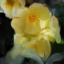

In [32]:
from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "image": images,
})
})
gen_dataset = dataset["train"]
gen_dataset[0]['image']

In [33]:
import matplotlib.pyplot as plt
def show_images(images, scores, 
                test_idx, f_name
               ):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text('gen {} \n {}'.format(test_idx, f_name))
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n')
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

lambda:  500.0


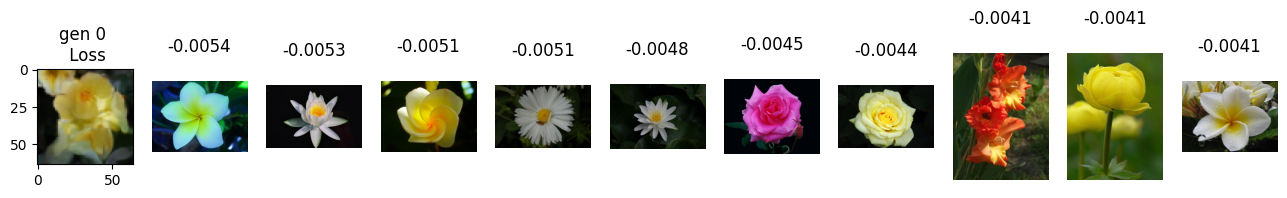

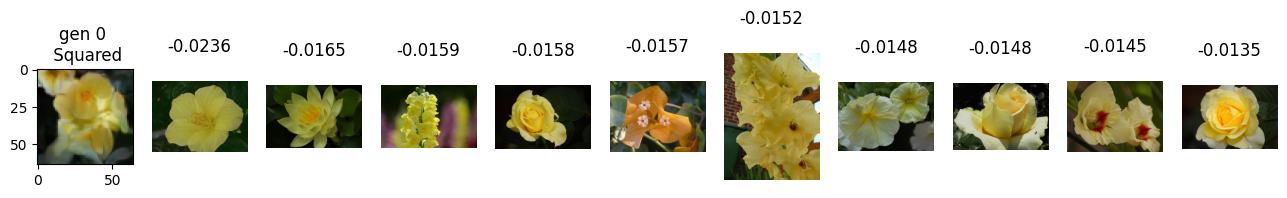

In [35]:
i = 0
for lamb_idx, lamb in enumerate(lamb_list):
    ####
    if lamb!=5e2:
        continue
    ####
    print('lambda: ', lamb) # choosing lambda without a lds benchmark is a bit tricky
    ####
    D = -f_scores_list[0][lamb_idx][i]
    topK = np.arange(10000)[D.argsort()[0:10]]
    plot_images = []
    plot_images.append(gen_dataset[i]['image'])
    # plot_images.append(train_dataset[i]['image'])
    for idx in topK:
        plot_images.append(train_dataset[int(idx)]['image'])
    
    show_images(plot_images, D[D.argsort()[0:10]], i, 'Loss')
    ####
    D = -f_scores_list[1][lamb_idx][i]
    topK = np.arange(10000)[D.argsort()[0:10]]
    plot_images = []
    plot_images.append(gen_dataset[i]['image'])
    # plot_images.append(train_dataset[i]['image'])
    for idx in topK:
        plot_images.append(train_dataset[int(idx)]['image'])
    
    show_images(plot_images, D[D.argsort()[0:10]], i, 'Squared')
    # break
